<a href="https://colab.research.google.com/github/danaverdene/Recommend/blob/main/deezer_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender system for Deezer dataset 

The markdown contains of the Deezer dataset analysis. The goal is to produce descriptive statistics in order to get more information about the dataset, with intention to propose a suitable recommender system which would connect app users with songs they will listen. 

## Descriptive statistics 

In [ ]:
#install packages in the google colab environment
!pip install surprise

#to be able to open csv file from google drive
!pip install -U -q PyDrive



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load all packages
# pip install scikit-surprise
import re
import os
import glob
import plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
from datetime import datetime
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy




In [ ]:
#loading additional packages to be able to open files from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#needed to change in order to access the data in my VS code environment
# Import CSV file
#data_path_processed = Path(os.path.abspath('')) / "../data/"
#data_deezer = pd.read_csv(f'{data_path_processed}/train.csv',keep_default_na=False, na_values='NULL')

In [ ]:
#loading the train file from google drive - step 1

link = "https://drive.google.com/file/d/1N-Hd8MbK-9X4BwPdQsF2V-fWFBaeDwlt"
fluff, id = link.split('d/')
print(id) # Verify that you have everything after 'd/'


1N-Hd8MbK-9X4BwPdQsF2V-fWFBaeDwlt


In [ ]:
#loading the train file from google drive - step 2
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')
data_deezer = pd.read_csv("train.csv", keep_default_na=False, na_values="NULL")


In [ ]:
print(f'In the deezer dataset there are {len(data_deezer)} observations.')

In the deezer dataset there are 7558834 observations.


In [ ]:
data_deezer.count()

genre_id           7558834
ts_listen          7558834
media_id           7558834
album_id           7558834
context_type       7558834
release_date       7558834
platform_name      7558834
platform_family    7558834
media_duration     7558834
listen_type        7558834
user_gender        7558834
user_id            7558834
artist_id          7558834
user_age           7558834
is_listened        7558834
dtype: int64

In [ ]:
data_deezer.head(10)

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
5,7,1478382544,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
6,7,1478338409,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
7,7,1478353709,542335,71718,1,20080215,1,0,150,1,1,10325,2939,29,1
8,7,1479130924,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1
9,7,1479214304,542335,71718,1,20080215,1,2,150,1,1,51,2939,28,1


### Data fields
media_id - identifiant of the song listened by the user  
album_id - identifiant of the album of the song  
media_duration - duration of the song  
user_gender -  gender of the user  
user_id -  anonymized id of the user  
context_type - type of content where the song was listened: playlist, album ...  
release_date - release date of the song with the format YYYYMMDD  
ts_listen - timestamp of the listening in UNIX time  
platform_name - type of os  
platform_family - type of device  
user_age - age of the user  
listen_type - if the songs was listened in a flow or not  
artist_id - identifiant of the artist of the song  
genre_id - identifiant of the genre of the song  
is_listened - 1 if the track was listened, 0 otherwise  


The variable we are interested in is is_listened. If the track was listened by the user for at least 30 seconds the variable has value 1, which means that the recommendation was suitable and matched user preferences. Otherwise the value is 0. The goal is to increase the number of 1.

In [ ]:
# counting unique values for each variable
for col in data_deezer.columns:
    unique_values = data_deezer[col].nunique()
    print(f"{col}: {unique_values}")

genre_id: 2922
ts_listen: 2256230
media_id: 452975
album_id: 151471
context_type: 74
release_date: 8902
platform_name: 3
platform_family: 3
media_duration: 1652
listen_type: 2
user_gender: 2
user_id: 19918
artist_id: 67142
user_age: 13
is_listened: 2


In the dataset, we have many unique values for variables, e.g. 2 922 unique types of genres, 67k different artists, almost 20k unique users in 13 different age groups. In order to get better overview, we select few variables and produce visual analysis.

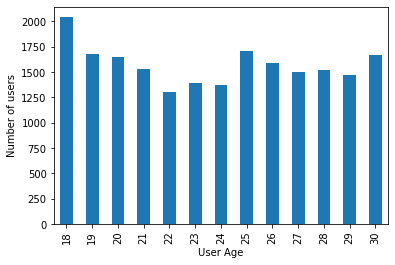

In [ ]:
# group the data by user_age and count the number of rows in each group
age_counts = data_deezer[['user_id', 'user_age']].groupby('user_age').nunique().reset_index()

# plot a bar chart
age_counts.plot(x = 'user_age', y = 'user_id',kind='bar', legend=False)
plt.xlabel('User Age') 
plt.ylabel('Number of users')
plt.show()

App users in the dataset are approximately evenly distibuted between age groups. 

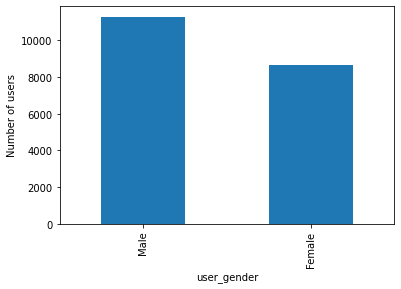

In [ ]:
gender_counts = data_deezer[['user_id', 'user_gender']].groupby('user_gender').nunique().reset_index()

# create a plot
ax = gender_counts.plot(x = 'user_gender', y = 'user_id', kind='bar',legend = False)
plt.ylabel('Number of users')
ax.set_xticklabels(['Male', 'Female'])
plt.show()

Males are prevailing app users.

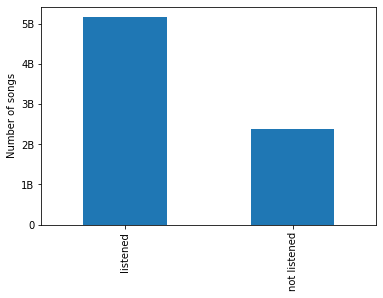

1    0.684033
0    0.315967
Name: is_listened, dtype: float64


In [ ]:
# count the number of occurrences of each value in the is_listened column
counts = data_deezer['is_listened'].value_counts()

# create a plot
counts.plot(kind='bar')
plt.ylabel('Number of songs')
plt.xticks([0, 1],["listened", "not listened"])
plt.yticks([0, 1000000, 2000000, 3000000, 4000000, 5000000], ["0", "1B", "2B", "3B", "4B", "5B"])
plt.show()

proportions = counts / len(data_deezer)
print(proportions)

Currently, the probability of song to be listened is 68%

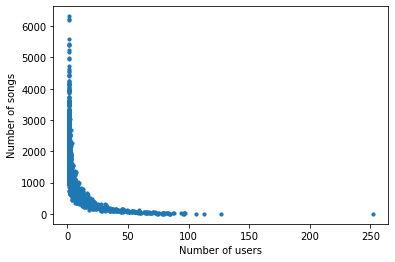

In [ ]:
# count number of users that listen to the number of songs
user_counts = data_deezer[['media_id', 'user_id']].groupby('user_id').count().reset_index().groupby('media_id').count().reset_index() 
user_counts = user_counts.rename(columns={'media_id':'number_of_songs', 'user_id':'number_of_users'})

plt.scatter(y='number_of_songs', x= 'number_of_users', data=user_counts, s = 10)
plt.xlabel('Number of users')
plt.ylabel('Number of songs')
plt.show()


Here we wanted to analyse how active app users are. From the graph above we see that the large amount of users listen to less than 2000 songs. There are approximately 250 users that don't listen or listen only few songs. Overall, it is hard to draw a conclusion from this graph due to extreme points. So we plot new graph to focus on left lower part of the graph:

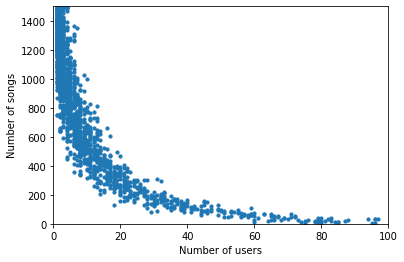

In [ ]:
plt.scatter(y='number_of_songs', x= 'number_of_users', data=user_counts, s = 10)
plt.xlabel('Number of users')
plt.ylabel('Number of songs')
plt.xlim(0, 100)
plt.ylim(0, 1500)
plt.show()

Basically, the conclusion here could be that users are quite active, for each number of songs value higher than 200 corresponds around 20 or fewer listeners. 

In [ ]:
# convert Unix time into date time object
data_deezer['dt_listen'] = pd.to_datetime(data_deezer['ts_listen'], unit='s')
data_deezer.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,dt_listen
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0,2016-12-01 13:00:15
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1,2016-11-30 22:25:35
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1,2016-11-19 13:59:13
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0,2016-11-26 09:21:38
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,2016-11-05 18:02:54


In [ ]:
# grouping data by day (disrregarding time)
daily_counts = data_deezer.groupby(data_deezer['dt_listen'].dt.date)['media_id'].count()
daily_counts.head()

dt_listen
1970-01-01    194
1970-01-02      1
1970-01-07      1
1970-01-11     53
1980-01-06     78
Name: media_id, dtype: int64

Probably some of the dates were not assigned correctly, since there are songs listened in year of 1970, to find this out we chech yearly counts:

In [ ]:
yearly_counts = data_deezer.groupby(data_deezer['dt_listen'].dt.year)['media_id'].count()
print(yearly_counts)

dt_listen
1970        249
1980        379
1996          1
2001          2
2008         19
2009         96
2010          7
2011          7
2012          1
2013         19
2014          3
2015         29
2016    7558022
Name: media_id, dtype: int64


Indeed, there are years that not suppoused to be in this dataset. This information should be considered when producing further analysis.

<AxesSubplot:xlabel='dt_listen'>

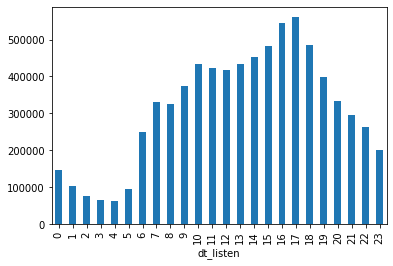

In [ ]:
hourly_counts = data_deezer.groupby(data_deezer['dt_listen'].dt.hour)['media_id'].count()
hourly_counts.plot(kind='bar')

The most popular listening hours are evening hours, but still there are many people listening to the music by night

In [ ]:
# exploring release date. It was not possible to convert it into datetime variable because of Out of bounds value timestamp. 
# so first we remove it
mask = data_deezer['release_date'] < 22620411
data_deezer = data_deezer[mask]

data_deezer['dt_release'] = pd.to_datetime(data_deezer['release_date'].astype(str), format='%Y%m%d')
yearly_counts_rel = data_deezer.groupby(data_deezer['dt_release'].dt.year)['media_id'].count()

# Print the resulting series
print(yearly_counts_rel)

dt_release
1900       1554
1901        687
1902         47
1903        405
1905         12
         ...   
2013     495831
2014     578543
2015     980479
2016    2664455
2017       1013
Name: media_id, Length: 87, dtype: int64


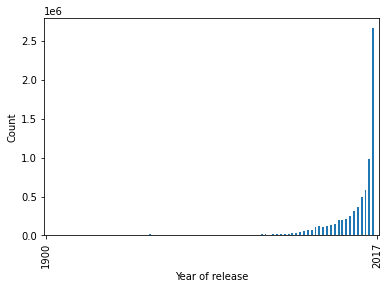

In [ ]:
ax = yearly_counts_rel.plot(x = 'dt_release', y = 'media_id', kind='bar',legend = False)
plt.xlabel('Year of release')
plt.ylabel('Count')
ax.set_xticks([0, len(yearly_counts_rel)-1])  # Set the tick positions to first and last values
plt.show()

The songs released in latest years prevalent in the app 

<AxesSubplot:>

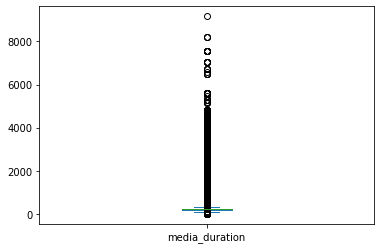

In [ ]:
# plotting music duration statistics. First removing extreme point of 60000 sec which is probably a typo
mask2 = data_deezer['media_duration'] < 50000
data_deezer = data_deezer[mask2]
data_deezer['media_duration'].plot(kind='box')

There are many extreme values so we can't clearly see the values of quantiles. To get more information we calculate values:

In [ ]:
# calculate the mean, median, and quantiles of music duration

mean = data_deezer['media_duration'].mean()
quantiles = data_deezer['media_duration'].quantile([0.25, 0.5, 0.75])
minimum = data_deezer['media_duration'].min()
maximum = data_deezer['media_duration'].max()

# print the results
print('Mean:', "{:.2f}".format(mean))
print('Minimum:', minimum)
print('Maximum:', maximum)
print('25th Percentile:', quantiles[0.25])
print('50th Percentile or median:', quantiles[0.5])
print('75th Percentile:', quantiles[0.75])

Mean: 231.14
Minimum: 0
Maximum: 9158
25th Percentile: 196.0
50th Percentile or median: 222.0
75th Percentile: 254.0


Average song duration is almost 4min, however maximum is about 2.5 hours, which is either typo or podcast (if there are podcasts in this set). As for minimum duration, here is 0 seconds, which could be mistaken number again. 

First - rather simple approach is - to start with the User base collaborative filtering.

In [ ]:
#using the training dataset
import copy
train = copy.deepcopy(data_deezer)

#reducing the size of the dataset
train_reduced = train.sample(frac=0.3)
print(train_reduced.shape)
print(len(train_reduced["user_id"]))
print(len(train_reduced["media_id"]))
print(train.head())


(2267650, 15)
2267650
2267650
   genre_id   ts_listen  media_id  album_id  context_type  release_date  \
0     25471  1480597215    222606     41774            12      20040704   
1     25571  1480544735    250467     43941             0      20060301   
2        16  1479563953    305197     48078             1      20140714   
3         7  1480152098    900502     71521             0      20001030   
4         7  1478368974    542335     71718             0      20080215   

   platform_name  platform_family  media_duration  listen_type  user_gender  \
0              1                0             223            0            0   
1              2                1             171            0            0   
2              2                1             149            1            1   
3              0                0             240            0            1   
4              0                0             150            0            1   

   user_id  artist_id  user_age  is_listened

Treating is_listened as an explicit feedback, therefore we are fitting KNN Baseline and BaselinOnline models to whole train data. 

The KNNBaseline algorithm is based on the K-Nearest Neighbors (KNN) approach to collaborative filtering, where users or items are compared based on their similarity in order to make recommendations. In the case of KNNBaseline, the algorithm computes a baseline rating for each user and item based on the average rating for that user or item, and then computes the similarity between users or items based on the deviations from these baselines.

BaselineOnly computes the average rating for each user and item, and using these baselines to make recommendations.

In [ ]:
from surprise import SVD, SVDpp, KNNBaseline, BaselineOnly, KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate

# Compare performance of two different algorithms
reader = Reader(rating_scale = (0, 1))

listened = Dataset.load_from_df(train_reduced[['user_id', 'media_id', 'is_listened']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBaseline(), BaselineOnly()]:
    results = cross_validate(algorithm, listened, measures=['RMSE'], cv = 3, verbose = False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Model']))
    benchmark.append(tmp)
    
df_benchmark = pd.DataFrame(benchmark).set_index('Model').sort_values('test_rmse')
 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [ ]:
#saving the creating df into a csv file
drive.mount('/content/drive')
path = '/content/drive/My Drive/recom/output.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_benchmark.to_csv(f)

Mounted at /content/drive


In [ ]:
#opening the saved output
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#loading the train file from google drive - step 1

link_2 = "https://drive.google.com/file/d/1ipVq2NMnvv8eW5Y5VCKGt4mCQOdQTYUr"
fluff, id_2 = link_2.split('d/')
print(id_2) # Verify that you have everything after 'd/'

#loading the train file from google drive - step 2
downloaded_2 = drive.CreateFile({'id':id_2}) 
downloaded_2.GetContentFile('output.csv')
knn_baseline_results = pd.read_csv("output.csv", keep_default_na=False, na_values="NULL")

1ipVq2NMnvv8eW5Y5VCKGt4mCQOdQTYUr


In [ ]:
#printing the results
print(knn_baseline_results)

          Model  test_rmse   fit_time   test_time
0  BaselineOnly   0.410644  11.264328    8.891349
1   KNNBaseline   0.424254  67.427076  312.106858


In [ ]:
##using SVD++ algorithm

reader = Reader(rating_scale = (0, 1))

listened_2 = Dataset.load_from_df(train_reduced[['user_id', 'media_id', 'is_listened']], reader)

trainset, testset = train_test_split(listened_2, test_size = .2)

# We will use the SVD++ algorithm
algo = SVDpp()

# Train the algorithm on the trainset, and predict 'is_listened' for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE of predictions
accuracy.rmse(predictions) 

RMSE: 0.4095


0.40947584269097337